# Week 2 — Conflict Classification & MLflow Experiment Tracking

**Purpose:**  
This notebook aims to build and evaluate models that classify students into high vs. low conflict levels based on their social media behavior, sleep patterns, and mental health scores. We will also set up and use **MLflow** to track experiments, compare model performances, and version our outputs for reproducibility and collaboration.


# Setup and Imports


In [21]:
%load_ext autoreload
%autoreload 2

# Standard library imports
import pickle
import warnings

# Third-party imports
import matplotlib.pyplot as plt
import mlflow
import mlflow.data
import mlflow.sklearn
from mlflow.data.pandas_dataset import PandasDataset
from mlflow.models.signature import infer_signature
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    StandardScaler
)
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression



# Suppress sklearn precision/recall warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Suppress the MLflow integer‐column hint
warnings.filterwarnings(
    "ignore",
    message="Hint: Inferred schema contains integer column"
)

# Suppress the MLflow integer‐column hint
warnings.filterwarnings(
    "ignore",
    message="Hint: Inferred schema contains integer column"
)


import sys
sys.path.append('../src')
from utils import (
    create_binary_conflict, 
    continent_dict,
    RareCategoryGrouper,
    CountryToContinentMapper,
    run_classification_experiment
)

# Set random seed for reproducibility
np.random.seed(42)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MLflow Setup


In [2]:
# Set MLflow tracking URI to local directory
mlflow.set_tracking_uri("file:../mlruns")

# Create or get experiment
experiment_name = "Classification_Conflicts"
mlflow.set_experiment(experiment_name)


<Experiment: artifact_location='file:///Users/bobhosseini/Portfolio/SDS-social-sphere/submissions/team-members/bob-hosseini/notebooks/../mlruns/893441246500907044', creation_time=1749911245020, experiment_id='893441246500907044', last_update_time=1749911245020, lifecycle_stage='active', name='Classification_Conflicts', tags={'mlflow.sharedViewState.acb6d7554a592a34fe5dfdfa2dd78e66e549d816cb3ef47109f1b0108d483e80': 'deflate;eJxdksFu2zAMhl9l0DkY2qtvbpZuxZJhcLpgQDCkikTHBGTJEKkuXpF3H+W4dZIjP/4/KYp8UwQ6muYRHUNUhVIzFaKF+NB/h15izRxxnxjoM7GOvGNsYRKVZFRRa0cwU0P+OacLVS6XInJYg+mNg4/ypWF8zX6rWRMwvWe2f2aqDRbcBiJh8JPDuU9V8iQeAgeGwc6DS62QYnv5vJd1SNHAiwgv6SoXpVv65dz+Fo/NM25BsBGmjUlRm/4K1vc7MiHCFYzB7HQymXU66lYQcdQMBzHLfFHGWBw77S1YVbydzuQnep/j7aj4htaCn+INEu7RIfcr3U22syxPJ5/0+FStn3f3d7vq14+1tH9F+LvSR2zxXy49LkhsSyR+bzBSpNLIKFbmrmBY64UlEXyNIXVgN9oloCc/b2TL8vcck+QbtLBoO+6v8SF7HuR+fHJuDG9G14lDBXUEahZe713mo9mFvXZL9DAUnQdf40FM6lgekc5nSQzdcGAe1m0I3Hgg6X43HcnvLF4Nqzlb1On0H/lADH4='}>

# Loading cleand data



In [3]:
# Load cleaned data
with open('../data/data_cleaned.pickle', 'rb') as f:
    df_data = pickle.load(f)

# Display basic information
print("Dataset shape:", df_data.shape)
print("\nTarget variable distribution:")
print(df_data['Conflicts'].value_counts())
df_data.head()


Dataset shape: (702, 13)

Target variable distribution:
Conflicts
3    261
2    204
4    172
1     47
5     15
0      3
Name: count, dtype: int64


,Student_ID,Age,Gender,Academic_Level,Country,Daily_Usage,Platform,Academic_Affects,Sleep_Hrs,Mental_Health,Relationship_Status,Conflicts,Addicted_Score
0,1,19,Female,Undergraduate,Bangladesh,5.2,Instagram,Yes,6.5,6,In Relationship,3,8
1,2,22,Male,Graduate,India,2.1,Twitter,No,7.5,8,Single,0,3
2,3,20,Female,Undergraduate,USA,6.0,TikTok,Yes,5.0,5,Complicated,4,9
3,4,18,Male,High School,UK,3.0,YouTube,No,7.0,7,Single,1,4
4,5,21,Male,Graduate,Canada,4.5,Facebook,Yes,6.0,6,In Relationship,2,7


In [4]:
# find and print numeric columns
numeric_cols = df_data.select_dtypes(include=['number']).columns
print(numeric_cols)


Index(['Student_ID', 'Age', 'Daily_Usage', 'Sleep_Hrs', 'Mental_Health',
       'Conflicts', 'Addicted_Score'],
      dtype='object')


# Target Variable Creation and Class Analysis
- Creating binary target variable
- The minority class is about 30% of the majority class
- As the first try, we try class weighting first before doing any data resampling.

## Target creation and class analysis

Binary Conflict Classification:
Threshold: 3
Low Conflict (0-3): 515 samples
High Conflict (4-max): 187 samples
Class imbalance ratio: 36.31%
Class proportions:
Conflict_Binary
Low     0.733618
High    0.266382
Name: count, dtype: float64


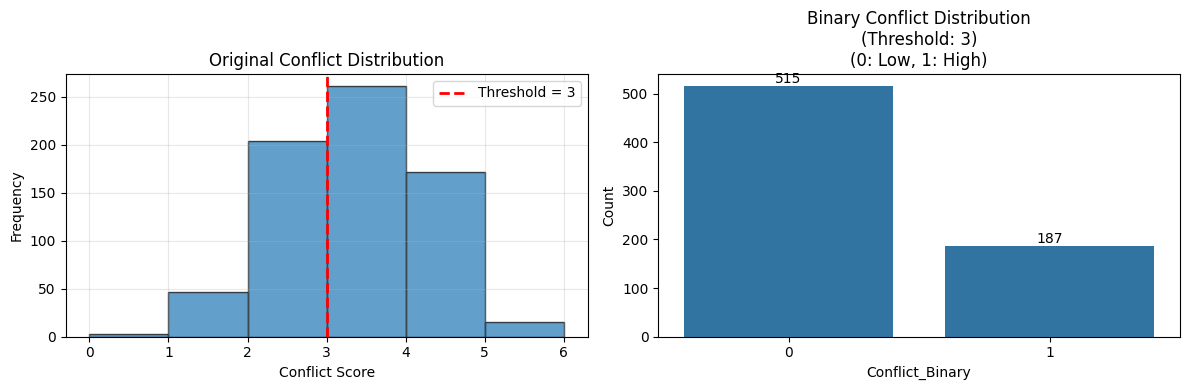

In [5]:
# create target variable using create_binary_conflict
df_data, results = create_binary_conflict(df_data, target_column='Conflicts', threshold=3, visualize=True)
   

# Test train split
- The train split is used for the modeling part.
- The test split is not involved in the modeling phase.

In [6]:
# split the data into train and test
from sklearn.model_selection import train_test_split

drop_cols = ['Student_ID', 'Addicted_Score', 'Conflict_Binary']

X_train_full, X_test, y_train_full, y_test = train_test_split(df_data.drop(columns=drop_cols), df_data['Conflict_Binary'], test_size=0.2, random_state=42)

# print the shape of the train and test sets
print(f"Train set shape: {X_train_full.shape}")
print(f"Test set shape: {X_test.shape}")

# print the shape of the train and test sets
print(f"Train set shape: {X_train_full.shape}")
print(f"Test set shape: {X_test.shape}")

X_train_full.head()

Train set shape: (561, 11)
Test set shape: (141, 11)
Train set shape: (561, 11)
Test set shape: (141, 11)


,Age,Gender,Academic_Level,Country,Daily_Usage,Platform,Academic_Affects,Sleep_Hrs,Mental_Health,Relationship_Status,Conflicts
166,20,Female,Undergraduate,Bangladesh,4.9,Instagram,Yes,6.4,5,Single,3
546,20,Female,Undergraduate,UAE,6.9,Instagram,Yes,6.1,5,In Relationship,4
285,21,Male,Graduate,UK,5.0,Facebook,Yes,6.6,6,In Relationship,3
362,20,Female,Undergraduate,Ireland,4.5,TikTok,Yes,7.4,7,Single,3
111,21,Female,Undergraduate,India,5.8,TikTok,Yes,5.9,6,In Relationship,3


# Preprocessing Pipeline
- Feature engineering by converting categorical features to numerical variables
- Scaling numerical features

## Define Column Groups

In [7]:
binary_cats       = ['Gender']         # boolean → 0/1
low_card_cols     = ['Relationship_Status', 'Academic_Level']                # few categories
high_card_cols    = ['Platform']                      # group rare then OHE
country_col       = ['Country']                                 # map to continent
numeric_cols      = df_data.drop(columns=drop_cols).select_dtypes(include=['number']).columns

## Defining the Preprocessing steps


In [8]:
# Boolean → int
binary_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

# Low-cardinality One-Hot
low_card_transformer = OneHotEncoder(handle_unknown='ignore')

# High-cardinality grouping + One-Hot
high_card_transformer = Pipeline([
    ('group_rare', RareCategoryGrouper(min_count=30)),
    ('onehot',    OneHotEncoder(handle_unknown='ignore'))
])

# Country → Continent → One-Hot
country_transformer = Pipeline([
    ('map_continent', CountryToContinentMapper(mapping=continent_dict)),
    ('onehot',        OneHotEncoder(handle_unknown='ignore'))
])

# Numeric scaling
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('bools',   binary_transformer,   binary_cats),
    ('low_ohe', low_card_transformer, low_card_cols),
    ('high_ohe',high_card_transformer,high_card_cols),
    ('cty_ohe', country_transformer,  country_col),
    ('nums',    numeric_transformer,  numeric_cols),
], remainder='drop')

## Apply preprocessing and inspect transformed features

Transformed feature matrix (first 5 rows):
   Gender_Male  Relationship_Status_Complicated  \
0          0.0                              0.0   
1          0.0                              0.0   
2          1.0                              0.0   
3          0.0                              0.0   
4          0.0                              0.0   

   Relationship_Status_In Relationship  Relationship_Status_Single  \
0                                  0.0                         1.0   
1                                  1.0                         0.0   
2                                  1.0                         0.0   
3                                  0.0                         1.0   
4                                  1.0                         0.0   

   Academic_Level_Graduate  Academic_Level_High School  \
0                      0.0                         0.0   
1                      0.0                         0.0   
2                      1.0                         0.0 

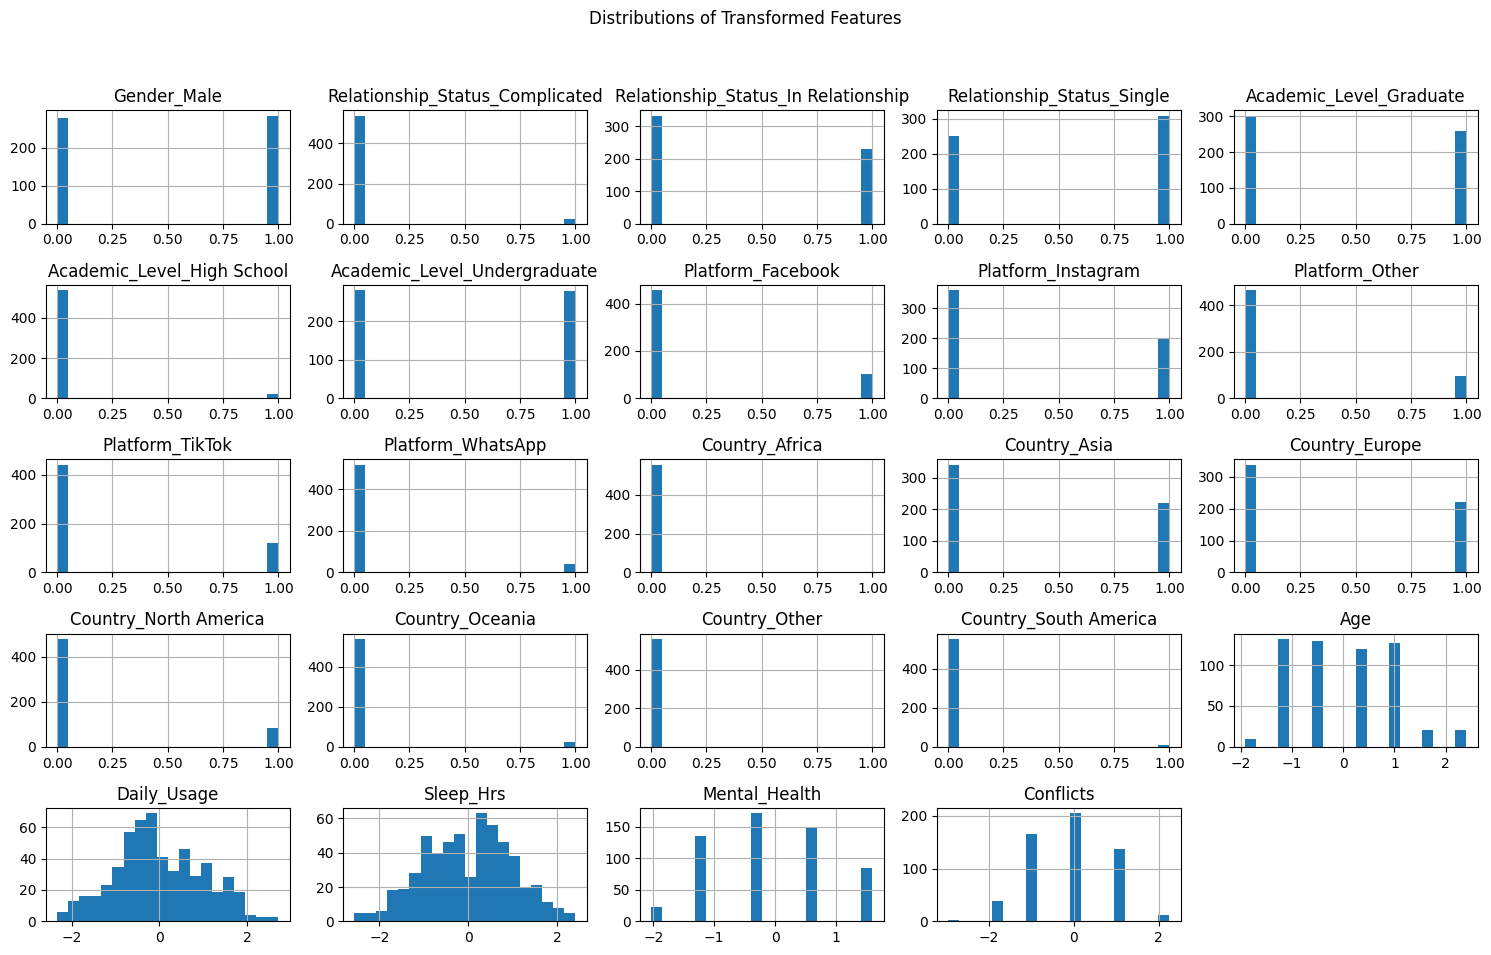

In [9]:
# 1. Fit the preprocessing step on the training data
preprocessor.fit(X_train_full)

# 2. Transform the training data
X_train_proc = preprocessor.transform(X_train_full)

# 3. Retrieve the transformed feature names
#    Note: get_feature_names_out is available on ColumnTransformer in sklearn >=1.0
from utils import get_feature_names
feature_names = get_feature_names(preprocessor)

# 4. Convert to DataFrame (densify if sparse)
if sparse.issparse(X_train_proc):
    X_train_proc = X_train_proc.toarray()

X_train_df = pd.DataFrame(X_train_proc, columns=feature_names)

# 5. Print the first few rows
print("Transformed feature matrix (first 5 rows):")
print(X_train_df.head())

# 6. Simple visualization: histograms for each feature
X_train_df.hist(bins=20, figsize=(15, 10))
plt.suptitle("Distributions of Transformed Features")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Sample data for MLflow logging

In [10]:
# after fitting your pipeline:
example_input = X_train_full.iloc[:5].copy()
# Convert integer columns to float
for col in example_input.select_dtypes(include=['int64']).columns:
    example_input[col] = example_input[col].astype('float')  

    # 1. Create Dataset objects for each split
train_ds = mlflow.data.from_pandas(
    df=X_train_full,
    source="../data/data_cleaned.pickle",
    name="social_sphere_train_v1"
)
test_ds = mlflow.data.from_pandas(
    df=X_test,
    source="../data/data_cleaned.pickle",
    name="social_sphere_test_v1"
)      
from utils import mlflow_dataset
mlflow_dataset = mlflow_dataset(X_train_full, X_test)

/opt/anaconda3/envs/c29env/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/data_cleaned.pickle'. Exception: 
  return _dataset_source_registry.resolve(
/opt/anaconda3/envs/c29env/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/opt/anaconda3/envs/c29env/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/data_cleaned.pickle'. Exception: 
  return _dataset_source_registry.resolve(
/opt/anaconda3/envs/c29env/lib/python3.12/site-packages/mlflow/data/dataset_source_re

# Classification pipeline: baseline model

## Cross validation setup
We will use cross-validation to evaluate the performance of the model.

In [11]:
# Define cross-validation settings
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,         # if you want to shuffle before splitting
    random_state=42       # ◀️ fix the RNG here
)
scoring = {
    "accuracy":   "accuracy",
    "precision":  "precision",
    "recall":     "recall",
    "f1_score":         "f1",
    "roc_auc":    "roc_auc"
}

## Train, evaluate, and log a baseline model

As the baseline model, we will use a dummy classifier that predicts the target variable based on these strategies:
- most_frequent
- prior
- uniform
- stratified

We will log the model to MLflow.

In [22]:
strategies = ["most_frequent", "prior", "uniform", "stratified"]
for strategy in strategies:
    baseline_pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("classifier", DummyClassifier(strategy=strategy))
    ])
    run_classification_experiment(
        name=f"baseline_dummy_{strategy}",
        estimator=baseline_pipeline,
        X_train=X_train_full,
        y_train=y_train_full,
        cv=cv,
        scoring=scoring,
        dataset=mlflow_dataset,
        hparams={"strategy": strategy},
        registered_model_name=f"conflict_baseline_dummy_{strategy}"
    )

Registered model 'conflict_baseline_dummy_most_frequent' already exists. Creating a new version of this model...
Created version '9' of model 'conflict_baseline_dummy_most_frequent'.
Registered model 'conflict_baseline_dummy_prior' already exists. Creating a new version of this model...
Created version '7' of model 'conflict_baseline_dummy_prior'.
Registered model 'conflict_baseline_dummy_uniform' already exists. Creating a new version of this model...
Created version '7' of model 'conflict_baseline_dummy_uniform'.
Registered model 'conflict_baseline_dummy_stratified' already exists. Creating a new version of this model...
Created version '7' of model 'conflict_baseline_dummy_stratified'.


# Classification Pipeline, Logistic Regression

In [ ]:
# Build your LR pipeline
lr_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# Run the experiment
run_classification_experiment(
    name=f"baseline_dummy_{strategy}",
    estimator=baseline_pipeline,
    X_train=X_train_full,
    y_train=y_train_full,
    cv=cv,
    scoring=scoring,
    dataset=mlflow_dataset,
    hparams={"strategy": strategy},
    registered_model_name=f"conflict_baseline_dummy_{strategy}"
)


Registered model 'conflict_baseline_dummy_stratified' already exists. Creating a new version of this model...
Created version '8' of model 'conflict_baseline_dummy_stratified'.


In [14]:
assert False

AssertionError: 

In [ ]:
def run_and_register_dummy_baseline(
    X_train_full,
    y_train_full,
    preprocessor,
    strategy: str,
    cv,
    scoring,
    dataset,
    registered_model_name: str = "conflict_baseline_dummy"
):
    """
    Runs cross‐validation for a single DummyClassifier strategy, logs metrics to MLflow,
    refits on the full training set, and registers the model.

    Parameters:
    - X_train_full, y_train_full: training data
    - preprocessor: sklearn Pipeline or ColumnTransformer for feature prep
    - strategy: one of DummyClassifier strategies ("most_frequent", "stratified", "uniform", "prior")
    - cv: cross‐validation splitter (e.g., StratifiedKFold instance)
    - experiment_name: MLflow experiment under which runs are logged
    - registered_model_name: name to register the final model in MLflow
    """
    
    run_name = f"baseline_dummy_{strategy}_cv"
    with mlflow.start_run(run_name=run_name):
        # Log inputs
        mlflow.log_input(dataset["train_ds"], context="training")    
        mlflow.log_input(dataset["test_ds"], context="test")

        # build pipeline
        baseline_pipeline = Pipeline([
            ("preprocessing", preprocessor),
            ("classifier", DummyClassifier(strategy=strategy))
        ])

        # log strategy
        mlflow.log_param("strategy", strategy)

        # cross‐validate
        cv_results = cross_validate(
            estimator=baseline_pipeline,
            X=X_train_full,
            y=y_train_full,
            cv=cv,
            scoring=scoring,
            return_train_score=False,
            n_jobs=-1
        )

        # log mean and std for each metric
        for metric in scoring:
            scores = cv_results[f"test_{metric}"]
            mlflow.log_metric(metric,      scores.mean())
            mlflow.log_metric(f"{metric}_std", scores.std())

        # raw fold scores as artifact
        with open("cv_fold_scores.json", "w") as fp:
            json.dump({k: v.tolist() for k, v in cv_results.items()}, fp)
        mlflow.log_artifact("cv_fold_scores.json")

        # refit on full training data
        baseline_pipeline.fit(X_train_full, y_train_full)

        # infer signature and example
        example_input = X_train_full.iloc[:5]
        example_preds = baseline_pipeline.predict(example_input)
        signature = infer_signature(example_input, example_preds)

        # log & register
        mlflow.sklearn.log_model(
            sk_model=baseline_pipeline,
            name=f"baseline_model_cv_{strategy}",
            registered_model_name=f"{registered_model_name}_{strategy}",
            signature=signature,
            input_example=example_input
        )
